In [130]:
import pickle

import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import beta
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import rankdata, kendalltau, spearmanr

import plotly.graph_objects as go
from tqdm.notebook import tqdm
from pathlib import Path

sns.set_theme("paper", "white")

In [149]:
df_users = pd.read_csv("./DSock/Active_Users.csv", index_col=0)
df_user_express = pd.read_csv("./DSock/User_Expressed_Influence_Rank.csv")
display(df_users.head())
display(df_user_express.head())

timeline = pd.date_range("2020-09-03-03:59:59", periods=6, tz="utc")

,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Strategy
1,A10IUXCZBNYUXC,Jacob_1907,2658,f,f,f,17,0,1,25,...,2.0,2.0,2.0,1.0,1.0,2.0,1.0,4.0,2.0,NaN
2,A15F2JTVAJXITI,Luke_3376,2297,f,t,f,0,0,0,0,...,1.0,3.0,1.0,3.0,1.0,3.0,1.0,4.0,1.0,NaN
3,A173A97OFDAX9F,Claire_679,2601,f,f,f,0,0,0,4,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,NaN
4,A18XVBWB2A270I,Katherine_2323,2338,f,t,f,0,0,0,0,...,1.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,3.0,NaN
5,A1AIMKA54UBYIQ,Asia_4906,2638,f,f,f,1,0,1,9,...,3.0,3.0,2.0,1.0,2.0,2.0,2.0,4.0,3.0,NaN


,MTurk_ID,username,id,Role,survey,mentions,per_rank
0,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,1,0,0.0
1,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,2,0,0.0
2,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,3,0,0.0
3,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,4,0,0.0
4,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,5,0,0.0


In [3]:
df_posts = pd.read_csv("./DSock/direct_influence/posts_with_senti_and_topic.csv", parse_dates=["createdAt"])
df_comts = pd.read_csv("./DSock/direct_influence/comments_with_senti_and_topic.csv", delimiter=",", parse_dates=["createdAt"]).dropna(subset=["CommenterId", "PostId"])
df_views = pd.read_csv("./DSock/postViews.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_likes = pd.read_csv("./DSock/Likes.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_repts = pd.read_csv("./DSock/ReportUsers.csv", delimiter="|", parse_dates=["createdAt"])

print(f"posts: {df_posts.shape}, comments: {df_comts.shape}, views: {df_views.shape}, likes: {df_likes.shape}, reports: {df_repts.shape}")

df_likes["UserId"] = df_likes["UserId"].astype(int)
df_likes["PostId"] = df_likes["PostId"].astype(int)

df_comts["CommenterId"] = df_comts["CommenterId"].astype(int)
df_comts["PostId"] = df_comts["PostId"].astype(int)

df_annot_posts = pd.read_csv("./DSock/posts_anno_labels.csv")
df_posts = df_posts.merge(df_annot_posts[["post_id", "majority_topic_label", "majority_sent_label"]], left_on="PostID", right_on="post_id")

df_annot_comts = pd.read_csv("./DSock/comments_anno_labels.csv")
df_comts = df_comts.merge(df_annot_comts[["comment_id", "majority_topic_label", "majority_sent_label"]], left_on="id", right_on="comment_id")

posts: (1057, 11), comments: (1615, 11), views: (234178, 10), likes: (1034, 6), reports: (46, 6)


In [4]:
G = nx.DiGraph()
for u, uname, obsr, sock in df_users[["id", "username", "isObserver", "isPuppet"]].values:
    G.add_node(f"u{u}", id=u, kind="user", name=uname, observer=(obsr == "t"), sock=(sock == "t"))
    if obsr == "t":
        G.nodes[f"u{u}"]["color"] = "obsr"
    elif sock == "t":
        G.nodes[f"u{u}"]["color"] = "sock"
    else:
        G.nodes[f"u{u}"]["color"] = "part"

for p, u, t, polar, score, topic in df_posts[["PostID", "AuthorId", "createdAt", "majority_sent_label", "scores", "majority_topic_label"]].values:
    if f"u{u}" in G.nodes:
        G.add_node(f"p{p}", id=p, kind="post", time=t, user=u, polar=polar, score=score, topic=topic)

for c, u, p, t, polar, score, topic in df_comts[["id", "CommenterId", "PostId", "createdAt", "majority_sent_label", "scores", "majority_topic_label"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"c{c}", id=c, kind="comt", time=t, user=u, polar=polar, score=score, topic=topic)
        G.add_edge(f"c{c}", f"p{p}", kind="known", time=t, weight=1)
        G.add_edge(f"p{p}", f"c{c}", kind="known", time=t, weight=1)

for l, u, p, t in df_likes[["id", "UserId", "PostId", "createdAt"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"l{l}", user=f"u{u}", post=f"p{p}", time=t, id=l, kind="like",
                   topic=G.nodes[f"p{p}"]["topic"], polar=G.nodes[f"p{p}"]["polar"], score=1)
        G.add_edge(f"u{u}", f"l{l}", time=t, weight=1, kind="infer")
        G.add_edge(f"l{l}", f"p{p}", time=t, weight=1, kind="known")

for u, p, t, v in df_views[["UserId", "PostId", "createdAt", "id"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"v{v}", user=f"u{u}", post=f"p{p}", time=t, id=v, kind="view",
                   topic=G.nodes[f"p{p}"]["topic"], polar=G.nodes[f"p{p}"]["polar"], score=1)
        G.add_edge(f"u{u}", f"v{v}", time=t, weight=1, kind="infer")
        G.add_edge(f"v{v}", f"p{p}", time=t, weight=1, kind="known")

user_view = {u: set() for u in G if u[0] == "u"}
for u, p, t, v in df_views[["UserId", "PostId", "createdAt", "id"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        user_view[f"u{u}"].add(f"v{v}")

for p in tqdm(G):
    if p[0] == "p":
        u = f"u{G.nodes[p]['user']}"
        for v in user_view[u]:
            if G.nodes[v]["time"] <= G.nodes[p]["time"]:
                G.add_edge(p, v, time=G.nodes[v]["time"], weight=1, kind="infer")

In [77]:
with open("res/pagerank/0.9-0.5-0.5.pkl", "rb") as fp:
    d = pickle.load(fp)

In [78]:
df_users[df_users["id"] == 2340]

,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Strategy
7,A1CGW3DQ5JRSJH,Asia_3576,2340,f,t,f,0,0,0,0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,NaN


In [79]:
user_list = df_users["id"].tolist()
# user_list = df_users[df_users["isObserver"] == "f"]["id"].tolist()

In [80]:
obsr_list = [f"u{u}" for u in df_users[df_users["isObserver"] == "t"]["id"]]
pr_alpha = 0.9
beta_a = 0.5
beta_b = 0.5
keyq = [(node_name, t, topic, polar, pr_alpha, beta_a, beta_b)
        for node_name in obsr_list for t in range(1,6) for topic in range(8) for polar in [0, 2]
       ]

In [81]:
property_full = {k: d[k]["full_graph"] for k in tqdm(keyq)}
property_exps = {k: d[k]["exps_graph"] for k in tqdm(keyq)}

df_full = pd.DataFrame.from_dict(property_full, orient="index")
df_exps = pd.DataFrame.from_dict(property_exps, orient="index")

In [82]:
print(df_exps.max())

nodes         189.000
edges         194.000
components     92.000
density         0.333
diameter        0.000
degree          1.636
dtype: float64


In [103]:
use_color = sns.color_palette("Set1")
use_color

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

/home/rui/venvs/gcn/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


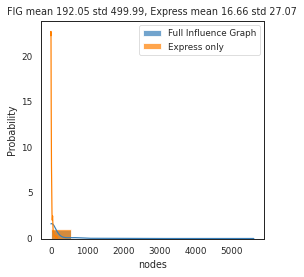

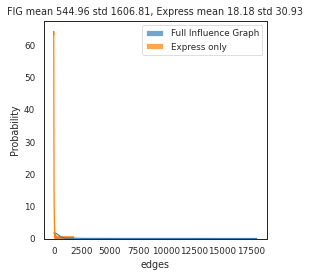

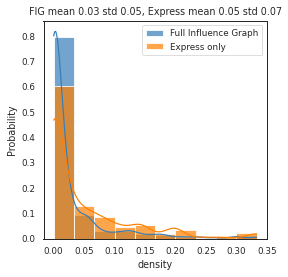

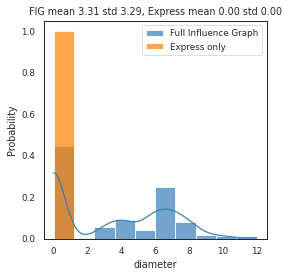

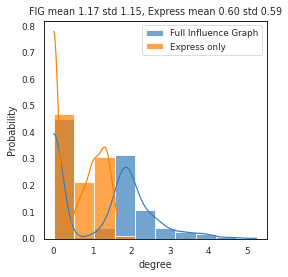

In [125]:
def plot_hist(name="nodes", xlabel="", ylabel="", title=""):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot()
    
    _, bins = np.histogram(df_full[name], bins=10)

    sns.histplot(df_full[name], bins=bins, ax=ax, stat="probability", label="Full Influence Graph", color=use_color[1], alpha=0.7, kde=True)
    sns.histplot(df_exps[name], bins=bins, ax=ax, stat="probability", label="Express only", color=use_color[4], alpha=0.7, kde=True)

    ax.set_title(f"FIG mean {df_full[name].mean():.2f} std {df_full[name].std():.2f}, Express mean {df_exps[name].mean():.2f} std {df_exps[name].std():.2f}")
    ax.set_xlabel(name)
    ax.legend()
    
    return fig

fig = plot_hist(name="nodes")
fig = plot_hist(name="edges")
fig = plot_hist(name="density")
fig = plot_hist(name="diameter")
fig = plot_hist(name="degree")

In [122]:
df_prop.mean(axis=1).to_frame().T
df_prop.std(axis=1).to_frame().T

,nodes,edges,components,density,diameter,degree
0,486.21,1581.084,0.0,0.068,3.069,1.157


In [127]:
pab = [(p, a, b)
    for p in [0.9, 0.7, 0.5, 0.3, 0.1]
    for a in [0.5, 0.9, 0.7, 0.3, 0.1]
    for b in [0.5, 0.9, 0.7, 0.3, 0.1]
]
obsr_list = [f"u{u}" for u in df_users[df_users["isObserver"] == "t"]["id"]]

In [133]:
def pr2rank(pr_value):
    ret = {u: 0 for u in user_list}
    for n in pr_value:
        if n[0] in ["p", "c"]:
            ret[G.nodes[n]["user"]] += pr_value[n]
    rank_value = [-ret[u] for u in user_list]
    rank = rankdata(rank_value, "max")
    # print(rankdata(rank, "min"))
    return dict(zip(user_list, rank))

def get_params(p, a, b):
    fpath = Path(f"res/pagerank/{p}-{a}-{b}.pkl")
    if not fpath.exists():
        return None
    with open(fpath, "rb") as fp:
        d = pickle.load(fp)
    keyq = [(node_name, t, topic, polar, p, a, b)
            for node_name in obsr_list for t in range(1, 6) for topic in range(8) for polar in [0, 2]
            ]
    ranks = [(k, pr2rank(d[k]["pr"])) for k in keyq]
    return ranks

ret = [get_params(*tup) for tup in tqdm(pab)]

In [143]:
keys = [x[0] for r in ret if r is not None for x in r]
values = [x[1] for r in ret if r is not None for x in r]

rank_dict = dict(zip(keys, values))

In [70]:
example = pr2rank(d[('u2337', 1, 4, 0, 0.9, 0.5, 0.5)]["pr"])

rank_dict = {k[:4]: pr2rank(d[k]["pr"]) for k in tqdm(keyq)}

In [145]:
df_inf = pd.DataFrame.from_dict(rank_dict, orient="index")
display(df_inf.head())

2658  2297  2601  2338  2638  2701  2340  2719  2667  \
u2297 1 0 0 0.9 0.5 0.5   116   116   116   116   116   116   116   116   116   
          2 0.9 0.5 0.5   116   116   116   116   116     2   116     6   116   
        1 0 0.9 0.5 0.5   116   116   116   116   116   116   116   116   116   
          2 0.9 0.5 0.5   116   116   116   116     2     3   116     4   116   
        2 0 0.9 0.5 0.5   116   116   116   116   116   116   116   116   116   

                         2342  ...  2636  2734  2657  2441  2714  2313  2337  \
u2297 1 0 0 0.9 0.5 0.5   116  ...   116   116   116   116   116   116   116   
          2 0.9 0.5 0.5   116  ...     4   116   116   116   116   116   116   
        1 0 0.9 0.5 0.5   116  ...   116   116   116   116   116   116   116   
          2 0.9 0.5 0.5   116  ...   116   116   116   116   116   116   116   
        2 0 0.9 0.5 0.5   116  ...   116   116   116   116   116   116   116   

                         2350  2703  2749  
u2297 1 0 0 0.9 0.5 0.5   116   116   116  
          2 0.9 0.5 0.5   116   116   116  
        1 0 0.9 0.5 0.5   116   116   116  
          2 0.9 0.5 0.5   116   116   116  
        2 0 0.9 0.5 0.5   116   116   116  

[5 rows x 116 columns]

In [147]:
avg_inf = df_inf.mean(axis=0, level=[1, 4, 5, 6])
display(avg_inf)

,,,,2658,2297,2601,2338,2638,2701,2340,2719,2667,2342,...,2636,2734,2657,2441,2714,2313,2337,2350,2703,2749
1,0.9,0.5,0.5,115.586,116.0,115.794,116.0,105.522,105.574,116.0,95.658,110.761,116.0,...,110.869,116.000,105.430,116.000,116.000,116.0,116.0,116.0,116.000,116.0
2,0.9,0.5,0.5,103.717,116.0,111.257,116.0,107.847,96.629,116.0,97.392,104.809,116.0,...,110.279,116.000,105.221,110.906,112.607,116.0,116.0,116.0,110.461,116.0
3,0.9,0.5,0.5,103.811,116.0,106.261,116.0,109.506,94.107,116.0,100.914,91.936,116.0,...,110.656,116.000,107.971,110.726,111.399,116.0,116.0,116.0,110.676,116.0
4,0.9,0.5,0.5,106.763,116.0,95.660,116.0,104.268,93.276,116.0,96.923,89.105,116.0,...,110.265,101.744,106.699,110.344,110.958,116.0,116.0,116.0,105.419,116.0
5,0.9,0.5,0.5,105.373,116.0,91.669,116.0,103.643,86.884,116.0,96.125,92.050,116.0,...,109.847,100.610,106.699,112.164,110.882,116.0,116.0,116.0,99.702,116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.5,0.9,0.3,115.586,116.0,115.792,116.0,105.546,105.618,116.0,95.559,110.805,116.0,...,110.871,116.000,105.430,116.000,116.000,116.0,116.0,116.0,116.000,116.0
2,0.5,0.9,0.3,103.761,116.0,111.263,116.0,107.858,96.741,116.0,97.274,104.820,116.0,...,110.279,116.000,105.233,110.855,112.601,116.0,116.0,116.0,110.555,116.0
3,0.5,0.9,0.3,103.847,116.0,106.404,116.0,109.590,94.285,116.0,100.860,91.938,116.0,...,110.680,116.000,107.976,110.647,111.254,116.0,116.0,116.0,110.783,116.0
4,0.5,0.9,0.3,106.796,116.0,95.662,116.0,104.434,93.419,116.0,96.956,89.103,116.0,...,110.301,101.724,106.715,110.235,110.877,116.0,116.0,116.0,105.494,116.0


In [166]:
pab_done = set([k[4:] for k in keys])
pab_done = [tup for tup in pab if tup in pab_done]

In [172]:
df_cor = {tup: {(n, t): avg_inf.loc[(t, *tup), n] for n, t in df_user_express[["id", "survey"]].values} for tup in tqdm(pab_done)}

In [174]:
df_user_express

,MTurk_ID,username,id,Role,survey,mentions,per_rank
0,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,1,0,0.000
1,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,2,0,0.000
2,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,3,0,0.000
3,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,4,0,0.000
4,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,5,0,0.000
...,...,...,...,...,...,...,...
575,ASQ460H8M8OOT,Willie_8565,2441,sockpuppet,1,0,0.000
576,ASQ460H8M8OOT,Willie_8565,2441,sockpuppet,2,4,0.957
577,ASQ460H8M8OOT,Willie_8565,2441,sockpuppet,3,0,0.000
578,ASQ460H8M8OOT,Willie_8565,2441,sockpuppet,4,0,0.000


In [73]:
df_user_express["prank"] = [avg_inf.loc[n, t] for n, t in df_user_express[["id", "survey"]].values]

In [74]:
def rank_metrics(df):
    return {
        "spearman": spearmanr(-df["per_rank"], df["prank"]),
        "kendaltau": kendalltau(-df["per_rank"], df["prank"]),
    }

In [75]:
pd.set_option('precision', 3)

In [76]:
metrics = pd.DataFrame.from_dict(rank_metrics(df_user_express))
metrics.index = ["correlation", "pvalue"]

display(metrics)

,spearman,kendaltau
correlation,4.565e-01,3.872e-01
pvalue,3.385e-31,9.782e-29
